In [1]:
import os
import sys
import json
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Switch to parent path to import local module
parent_path = str(os.getcwd()).split('notebooks')[0] # zeosyn_gen
os.chdir(parent_path)
print('Switched directory to:', os.getcwd())

import data.utils as utils
sys.modules['utils'] = utils # Way to get around relative imports in utils for ZeoSynGen_dataset # https://stackoverflow.com/questions/2121874/python-pickling-after-changing-a-modules-directory
from scipy.spatial import distance
from scipy.cluster import hierarchy
from matplotlib.colors import LogNorm

from data.syn_variables import zeo_cols

plt.rc('font', family='Helvetica')

/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics_eq/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Switched directory to: /home/jupyter/Elton/Zeolites/zeosyn_gen


/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics_eq/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def rmsd_matrix(A, B, squared=False, axis = 0):
    """
    Compute all pairwise distances between vectors in A and B.

    Parameters
    ----------
    A : np.array
        shape should be (M, K)
    B : np.array
        shape should be (N, K)

    Returns
    -------
    D : np.array
        A matrix D of shape (M, N).  Each entry in D i,j represnets the
        distance between row i in A and row j in B.

    See also
    --------
    A more generalized version of the distance matrix is available from
    scipy (https://www.scipy.org) using scipy.spatial.distance_matrix,
    which also gives a choice for p-norm.
    """
    M = A.shape[0]
    N = B.shape[0]

    assert A.shape[1] == B.shape[1], f"The number of components for vectors in A \
        {A.shape[1]} does not match that of B {B.shape[1]}!"

    A_dots = (A*A).sum(axis=1).reshape((M,1))*np.ones(shape=(1,N))
    B_dots = (B*B).sum(axis=1)*np.ones(shape=(M,1))
    if axis == 0:
        D_squared =  1/M*(A_dots + B_dots -2*A.dot(B.T))
    elif axis == 1:
        D_squared =  1/N*(A_dots + B_dots -2*A.dot(B.T))

    if squared == False:
        zero_mask = np.less(D_squared, 0.0)
        D_squared[zero_mask] = 0.0
        return np.sqrt(D_squared)

    return D_squared

def smoothsegment(seg, Nsmooth=100):
    '''
    Helper function for plotting circular dendrogram
    '''

    return np.concatenate([[seg[0]], np.linspace(seg[1], seg[2], Nsmooth), [seg[3]]])

In [3]:
# Load zeolite and OSDA descriptors
df_zeo = pd.read_csv('data/zeolite_descriptors.csv').drop(columns = ['Unnamed: 0'])
df_zeo = df_zeo[['Code']+zeo_cols]
df_zeo = df_zeo[df_zeo['Code'].str.len() == 3] # Restrict to only 3-lettered IZA code

In [4]:
df_zeo_emb = pd.read_csv('data/zeo_enc_emb.csv').drop(columns = ['Unnamed: 0'])
df_zeo_emb.columns = ['lat_'+x for x in df_zeo_emb.columns]
df_zeo_emb.insert(loc=0, column='Code', value=list(df_zeo['Code']))

# # Merge with zeolite features
# df_zeo_emb = pd.concat([df_zeo_emb, df_zeo[zeo_cols].reset_index().drop(columns='index')], axis=1)
# df_zeo_emb
df_zeo_emb

,Code,lat_0,lat_1,lat_2,lat_3,lat_4,lat_5,lat_6,lat_7,lat_8,...,lat_54,lat_55,lat_56,lat_57,lat_58,lat_59,lat_60,lat_61,lat_62,lat_63
0,CLO,-16.999700,3.871005,-10.315743,-3.792377,13.762295,-5.040712,-8.671482,-0.698270,4.147429,...,-4.392863,-1.541095,-21.341510,0.115660,-4.547840,-12.977031,4.614293,-4.197427,-24.403854,9.151077
1,CHI,-17.065320,12.338078,5.559419,11.318156,7.568119,-5.351173,22.904580,-10.363382,-7.641030,...,1.786707,1.550273,-17.929752,8.325283,0.084393,1.900537,-11.628046,-7.097776,-3.253670,3.519689
2,IFU,-14.778504,6.060910,-1.426875,-9.102889,5.585363,1.362228,-5.302301,4.726073,-0.733085,...,2.883535,-7.747762,-11.513396,-2.635167,-1.971030,-13.271550,2.580007,-0.003087,-13.769305,10.600550
3,ITN,-2.373476,3.920765,1.449968,0.662048,-0.502582,-1.368544,-4.850999,1.400378,-0.762785,...,11.839405,-1.325767,4.185457,3.092966,3.170729,-7.234015,-3.600306,-7.881634,2.676252,-1.934217
4,IRY,-10.311182,6.004883,-0.065245,-9.663789,-4.148163,0.471312,-9.307171,-3.747348,-0.309015,...,6.990601,-6.851439,-7.740309,-0.643385,-10.437519,-10.829327,5.151411,2.485285,-7.742987,9.063847
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,AFO,-3.220432,-10.656203,1.580445,3.754254,0.740787,-8.979926,16.790253,1.464763,-2.976261,...,-7.871162,1.173839,-8.013350,2.902317,2.306992,-2.252126,-3.435547,2.928068,-4.669706,-7.423537
252,YFI,-2.058191,-9.881257,3.897896,5.153137,-9.328855,9.506042,-7.916310,1.034148,0.199676,...,10.622919,9.944772,-2.332705,11.015851,2.460995,6.583286,-5.843066,-2.995911,2.229824,-1.738299
253,PSI,-3.899110,3.483726,-2.097875,-3.618715,-1.556773,-3.050927,-2.924460,2.238291,0.359235,...,3.957314,-2.364854,-6.407447,0.722425,-3.337491,-4.773679,2.399145,0.013294,-6.036491,1.790463
254,DON,-17.490856,0.572058,0.235598,-7.883140,-4.852068,19.170286,-0.048322,1.325923,-2.667350,...,5.743613,-2.860303,-6.422319,-8.876045,-0.534603,-11.572692,-0.270867,0.676856,-5.037138,5.044988


In [5]:
list(df_zeo.columns)

['Code',
 'zeo_num_atoms',
 'zeo_a',
 'zeo_b',
 'zeo_c',
 'zeo_alpha',
 'zeo_beta',
 'zeo_gamma',
 'zeo_volume',
 'zeo_largest_free_sphere',
 'zeo_largest_free_sphere_a',
 'zeo_largest_free_sphere_b',
 'zeo_largest_free_sphere_c',
 'zeo_largest_included_sphere',
 'zeo_largest_included_sphere_a',
 'zeo_largest_included_sphere_b',
 'zeo_largest_included_sphere_c',
 'zeo_largest_included_sphere_fsp',
 'zeo_num_atoms_per_vol',
 'zeo_chan_num_channels',
 'zeo_chan_0_dim',
 'zeo_chan_1_dim',
 'zeo_chan_2_dim',
 'zeo_chan_3_dim',
 'zeo_chan_4_dim',
 'zeo_chan_5_dim',
 'zeo_chan_0_di',
 'zeo_chan_0_df',
 'zeo_chan_0_dif',
 'zeo_chan_1_di',
 'zeo_chan_1_df',
 'zeo_chan_1_dif',
 'zeo_chan_2_di',
 'zeo_chan_2_df',
 'zeo_chan_2_dif',
 'zeo_chan_3_di',
 'zeo_chan_3_df',
 'zeo_chan_3_dif',
 'zeo_chan_4_di',
 'zeo_chan_4_df',
 'zeo_chan_4_dif',
 'zeo_chan_5_di',
 'zeo_chan_5_df',
 'zeo_chan_5_dif',
 'zeo_density',
 'zeo_asa_a2',
 'zeo_asa_m2_cm3',
 'zeo_asa_m2_g',
 'zeo_nasa_a2',
 'zeo_nasa_m2_cm3',


# Zeolite hierarchical clustering

In [6]:
zeo_feats_T = df_zeo_emb.T.drop(index='Code')
zeo_feats_T.columns = df_zeo_emb['Code']
zeo_feats_T

Code,CLO,CHI,IFU,ITN,IRY,ITV,EWT,NES,PAR,SVY,...,PTO,ANO,RSN,DOH,DDR,AFO,YFI,PSI,DON,SYT
lat_0,-16.9997,-17.06532,-14.778504,-2.373476,-10.311182,-13.311287,-5.275002,-0.298559,-1.630011,1.598352,...,-2.201405,-12.722419,0.134582,5.481839,-1.076777,-3.220432,-2.058191,-3.89911,-17.490856,-27.87731
lat_1,3.871005,12.338078,6.06091,3.920765,6.004883,5.440515,1.923835,-6.073203,-0.58648,3.648215,...,-1.225524,-15.330263,0.068608,-6.349476,-13.462265,-10.656203,-9.881257,3.483726,0.572058,21.402908
lat_2,-10.315743,5.559419,-1.426875,1.449968,-0.065245,-3.851482,-0.777691,1.152453,-0.026869,-3.435956,...,2.827838,11.22617,-3.659064,9.097228,2.620708,1.580445,3.897896,-2.097875,0.235598,-15.512678
lat_3,-3.792377,11.318156,-9.102889,0.662048,-9.663789,-3.868825,-2.608323,6.269427,1.653569,2.218723,...,-3.555836,1.154215,-0.400521,2.246295,-0.608118,3.754254,5.153137,-3.618715,-7.88314,-13.373454
lat_4,13.762295,7.568119,5.585363,-0.502582,-4.148163,-8.410511,-0.558586,-9.594589,-0.516661,-7.738407,...,0.48773,-5.229011,9.782579,-5.909808,-6.841621,0.740787,-9.328855,-1.556773,-4.852068,-7.928222
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
lat_59,-12.977031,1.900537,-13.27155,-7.234015,-10.829327,1.618703,-6.012091,9.63411,4.570532,-5.015646,...,-4.019341,-4.798225,-9.215219,3.937956,1.645959,-2.252126,6.583286,-4.773679,-11.572692,-20.907063
lat_60,4.614293,-11.628046,2.580007,-3.600306,5.151411,14.039786,3.936032,-0.191535,-2.903976,3.476963,...,2.48284,-12.538013,0.955399,7.257073,-11.342438,-3.435547,-5.843066,2.399145,-0.270867,10.882176
lat_61,-4.197427,-7.097776,-0.003087,-7.881634,2.485285,-1.283482,1.577913,-2.102205,0.09143,-3.672642,...,-6.820119,0.392298,6.789102,3.734977,-2.196307,2.928068,-2.995911,0.013294,0.676856,-5.859712
lat_62,-24.403854,-3.25367,-13.769305,2.676252,-7.742987,-6.802292,-0.954823,-5.009795,-1.937157,-1.815166,...,0.31152,6.73982,4.607987,-4.824497,4.921027,-4.669706,2.229824,-6.036491,-5.037138,-23.651394


In [7]:
zeo_feats_T_scaled = (zeo_feats_T-zeo_feats_T.min())/(zeo_feats_T.max()-zeo_feats_T.min()).astype(float)
zeo_feats_T_scaled = zeo_feats_T_scaled.astype(float)

In [8]:
zeo_rmsd = pd.DataFrame(rmsd_matrix(zeo_feats_T_scaled.T.to_numpy(), zeo_feats_T_scaled.T.to_numpy()),
                        index=zeo_feats_T_scaled.columns, columns=zeo_feats_T_scaled.columns)

/home/synthesisproject/anaconda3/envs/zeo_diffusion_metrics_eq/lib/python3.10/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


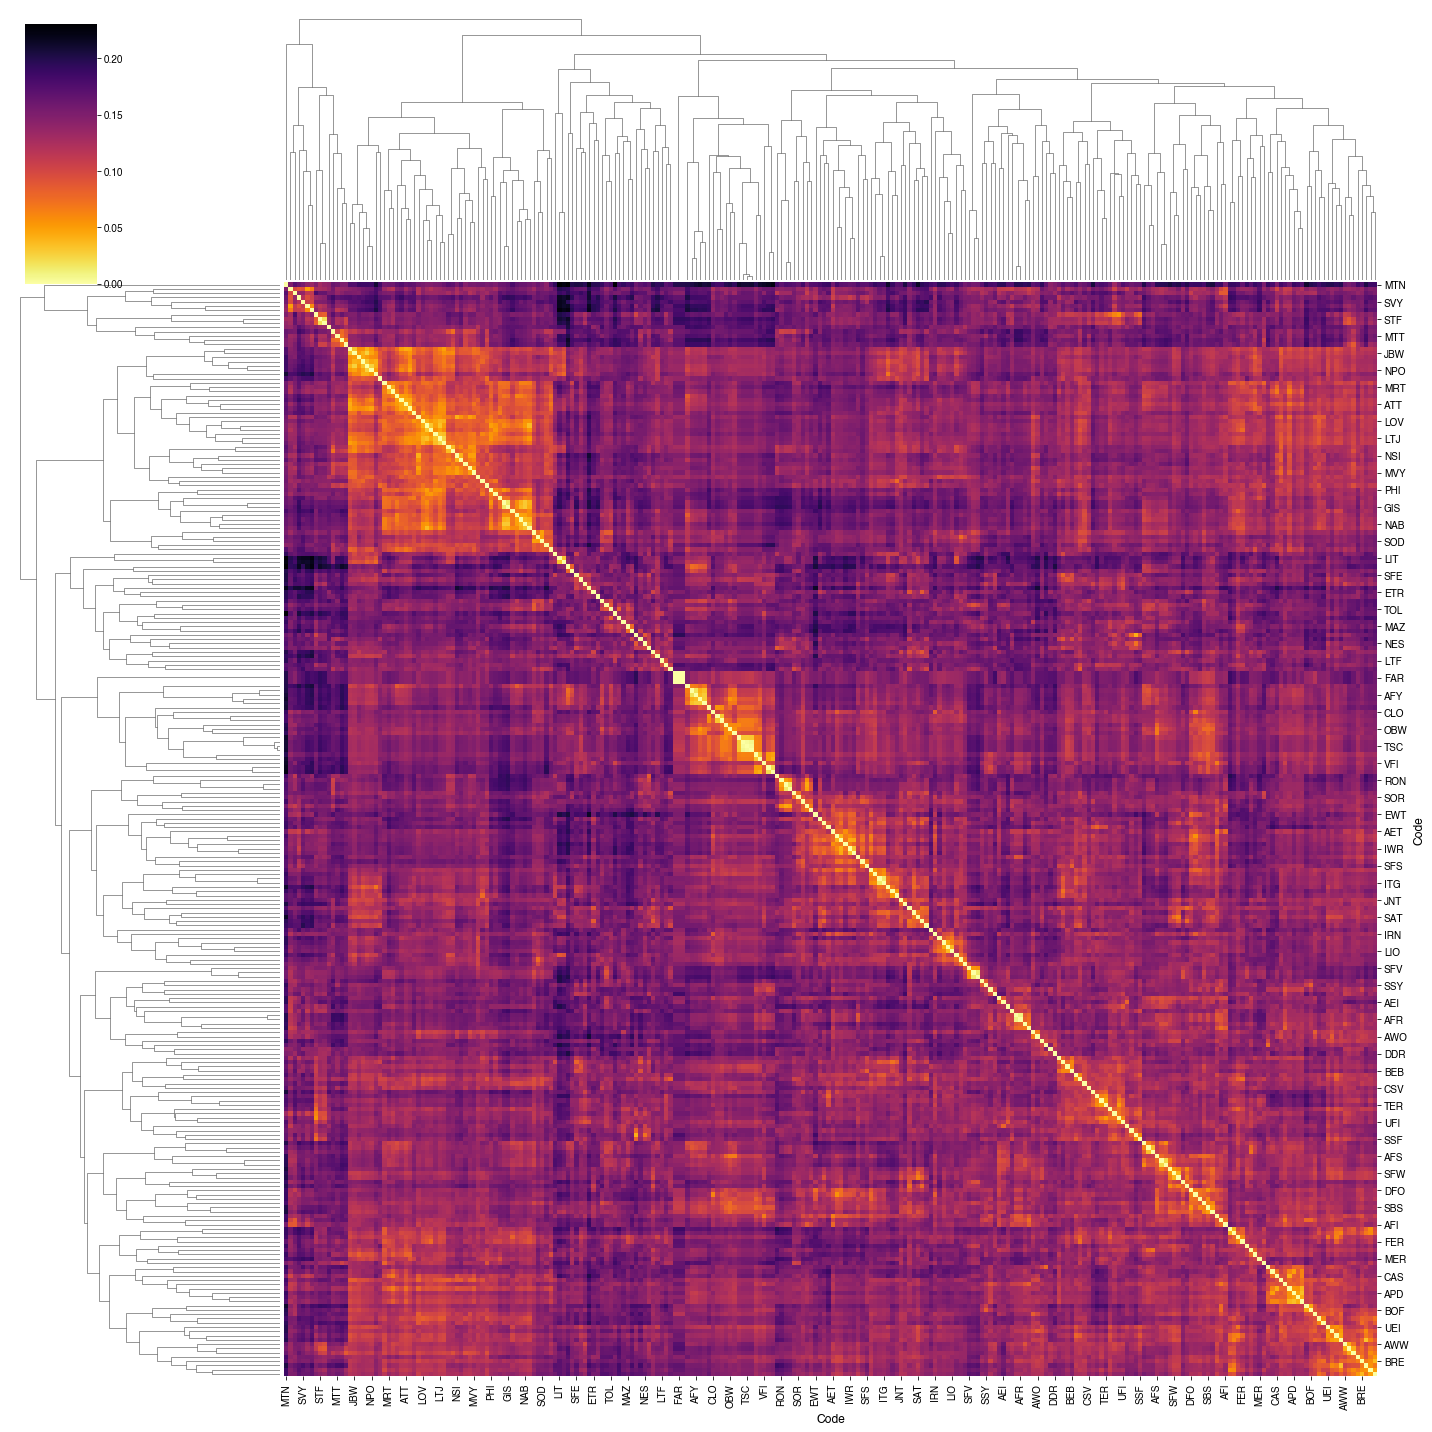

In [9]:
sns.clustermap(zeo_rmsd, cmap = "inferno_r", figsize=(20, 20))

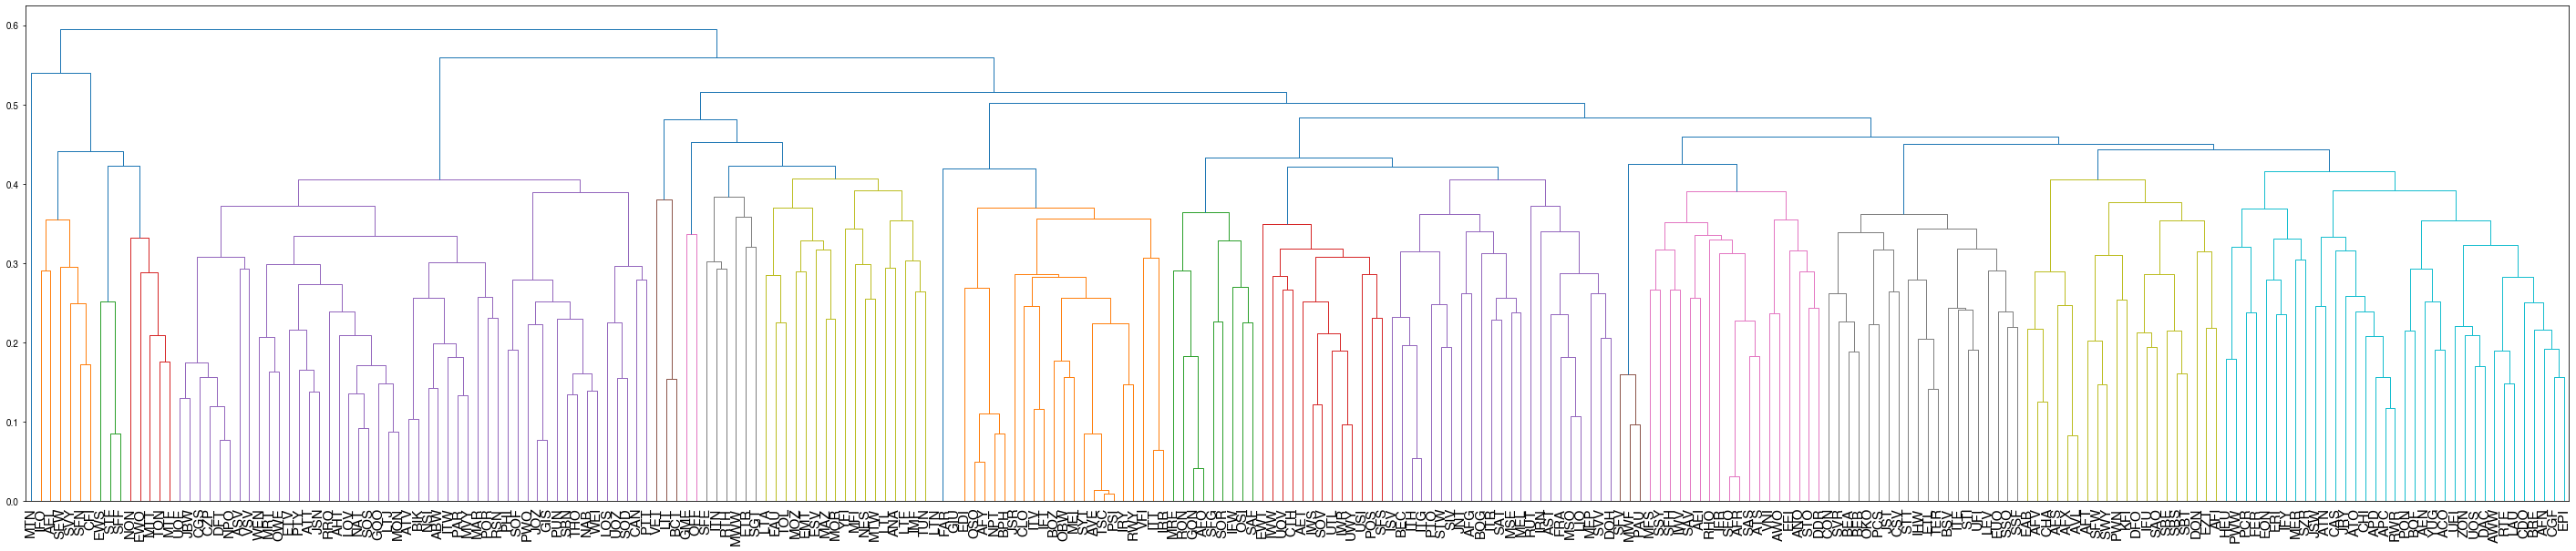

In [10]:
row_linkage = hierarchy.linkage(
    distance.pdist(zeo_rmsd.to_numpy()), method='average')

fig = plt.figure(figsize=(50, 10))
ax = fig.add_subplot(1, 1, 1)

dendro = hierarchy.dendrogram(row_linkage, labels = zeo_rmsd.columns.tolist(), ax=ax)
ax.tick_params(axis='x', which='major', labelsize=15)

plt.show()

<AxesSubplot:>

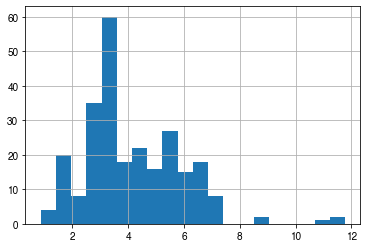

In [11]:
df_zeo['zeo_largest_free_sphere'].hist(bins=20)

<AxesSubplot:>

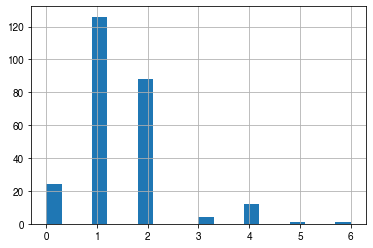

In [12]:
df_zeo['zeo_chan_num_channels'].hist(bins=20)

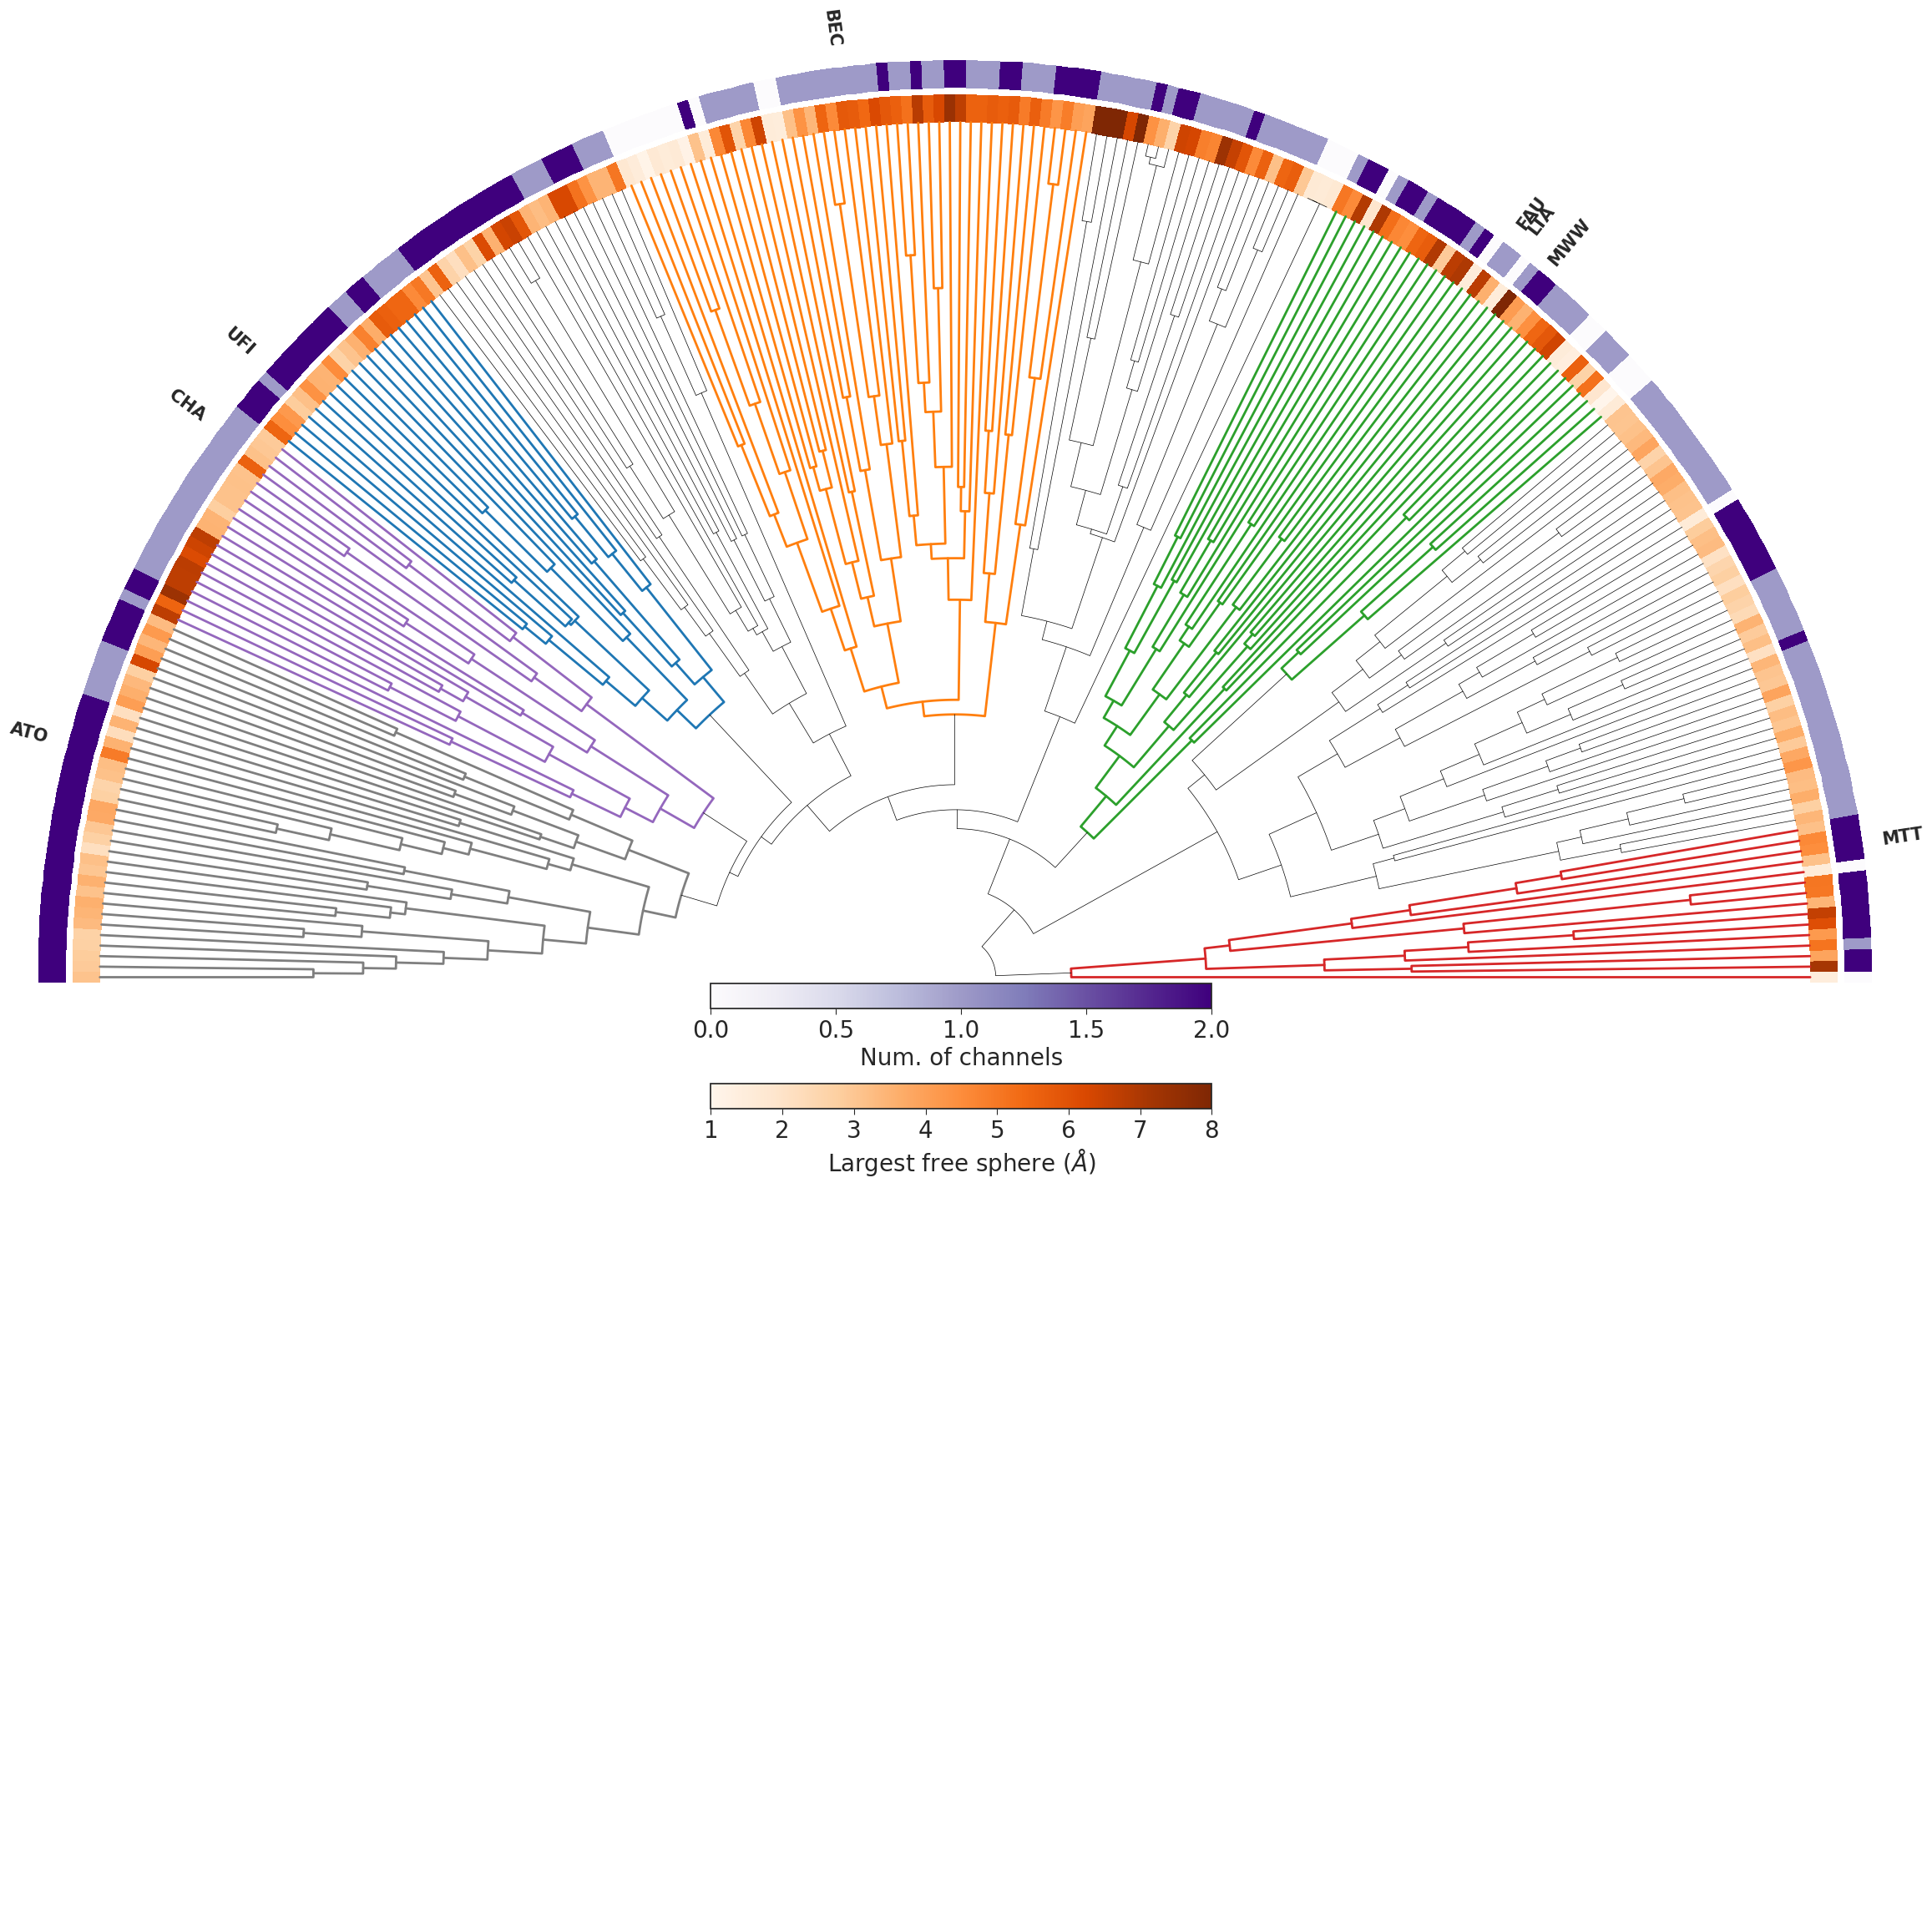

In [14]:
def plot_dendrogram(icoord, dcoord, figsize, prop1, prop2=None, prop3=None, prop4=None, labels = [], polar=False, save_path=None):
    if polar:
        radius = 20 # radius of circle
        dcoord = -dcoord*radius
#         dcoord = -np.log(dcoord+1)*radius
        gap = 0. # 0.1
        imax = icoord.max()
        imin = icoord.min()
        icoord = ((icoord - imin)/(imax - imin)*(1-gap) + gap/2)*np.pi

    n_prop = 0
    for p in prop1, prop2, prop3, prop4:
        if p != None:
            n_prop += 1
        
    with plt.style.context("seaborn-white"):
        fig = plt.figure(figsize=figsize, dpi=100)
        ax = fig.add_subplot(111, polar=polar)
        
        for xs, ys in zip(icoord, dcoord):
            start, end = xs[0], xs[2]
            
            # Default colors
            color = 'black'
            linewidth = 0.5
            highlighted_lw = 2
            
            # Grp F
            if (start > -0.01) and (end < 0.18) and (ys[1] > -17):
                color     = 'tab:red'
                linewidth = highlighted_lw

            # Grp E
            if (start > 0.7) and (end < 1.13) and (ys[1] > -15):
                color     = 'tab:green'
                linewidth = highlighted_lw
            
            # Grp D
            if (start > 1.4) and (end < 1.98) and (ys[1] > -15):
                color     = 'tab:orange'
                linewidth = highlighted_lw

            # Grp C
            if (start > 2.22) and (end < 2.47) and (ys[1] > -13):
                color     = 'tab:blue'
                linewidth = highlighted_lw
            
            # Grp B
            if (start > 2.47) and (end < 2.72) and (ys[1] > -15):
                color     = 'tab:purple'
                linewidth = highlighted_lw
            
            # Grp A
            if (start > 2.72) and (end < 3.2) and (ys[1] > -15):
                color     = 'tab:grey'
                linewidth = highlighted_lw
            
            if polar:
                xs = smoothsegment(xs)
                ys = smoothsegment(ys)
                
            
            ax.plot(xs,ys, color=color, 
                        linewidth=linewidth
                       )
        if polar:
            ax.spines['polar'].set_visible(False)
            ax.set_xticks([])
            ax.set_yticks([])
            Nxticks = len(labels)
            xticks = np.linspace(gap/2, 1-gap/2, Nxticks)
            ax.set_xticks(xticks*np.pi)

            ax.set_xticklabels(labels)
            ax.xaxis.grid(False)
            
            labels = []
            angles = []
            p1s = []
            p2s = []
            for label, angle in zip(ax.get_xticklabels(), xticks*np.pi):
                
                x,y = angle, 0.
                if label.get_text() in ['BEC', 'MWW', 'UFI', 'CHA', 'FAU', 'LTA', 'MTT', 'ATO']:
                    lab = ax.text(x,y, label.get_text(), fontweight='bold',
                                transform=label.get_transform(),
                                ha=label.get_ha(), va=label.get_va(),
                                fontsize=15,
                                )
                else:
                    lab = ax.text(x,y, '', 
                                transform=label.get_transform(),
                                ha=label.get_ha(), va=label.get_va(),
                                fontsize=15,
                                )

                degrees = np.degrees(angle)
                if degrees > 90 and degrees < 270:
                    degrees = degrees + 180
                lab.set_rotation(degrees)
                labels.append(lab)

                # Zeolite property
                p1 = df_zeo[df_zeo['Code']==label.get_text()][prop1].item()
                
                if prop2 != None:
                    p2 = df_zeo[df_zeo['Code']==label.get_text()][prop2].item()
                
# #                 Draw molecule
#                 smiles = label.get_text()
#                 mol = Chem.MolFromSmiles(smiles)
#                 o = Draw.MolDrawOptions()
#                 o.bondLineWidth = 5
#                 mol_img = Draw.MolToImage(mol, options=o, size=(300, 300))
#                 r = 0.41 # radius of molecule images in fractional
#                 x_cor, y_cor = -0.01, -0.02 # correction in x y fractions
#                 img_ax = fig.add_axes([0.5+r*np.cos(angle)+x_cor,0.5+r*np.sin(angle)+y_cor,0.045,0.045], anchor='C', zorder=1)
#                 img_ax.imshow(mol_img)
#                 img_ax.axis('off')
               
                angles.append(angle)
                p1s.append(p1)
                if prop2 != None:
                    p2s.append(p2)
            
            ax.set_xticklabels([])
            ax.set_ylim(top=0.66*n_prop) # distance between ends of dendrogram child nodes and xlabels
            
            
            # Define angles
            n = len(labels)
            start, end = angles[0], angles[-1]
            a = np.linspace(start, end, n) # angles
            
            # Property 1
            rad = np.linspace(0, 0.4, n) # radius of coloring, 1st and 2nd correspond to start and end of radius. 0 correspond to outmost radius
            r, th = np.meshgrid(rad, a)
            z = np.array(p1s)
            z = np.vstack(n*[z]).T

            mesh = ax.pcolormesh(th, r, z, cmap ='Oranges',
                                 vmin=1, vmax=8,
                                # vmax=3
                                # norm = LogNorm(),
)
            ax.plot(a, r, ls='none') 
            cbar_pos = fig.add_axes([0.415, 0.49-0.04*(n_prop-1), 0.2, 0.01]) # x, y, width, height
            cbar1 = fig.colorbar(mappable=mesh, cax=cbar_pos, orientation='horizontal', fraction=0.02, pad=-0.5)
            if prop1 == 'zeo_largest_free_sphere':
                prop1 = 'Largest free sphere ($\AA$)'
            cbar1.set_label(prop1, fontsize=20)
            cbar1.ax.tick_params(size=5, labelsize=20)

            # Property 2
            if prop2 != None:
                rad = np.linspace(0.5, 0.4+0.5*1, n) # radius of coloring, 1st and 2nd correspond to start and end of radius. 0 correspond to outmost radius
                r, th = np.meshgrid(rad, a)
                z = np.array(p2s)
                z = np.vstack(n*[z]).T

                mesh = ax.pcolormesh(th, r, z, cmap ='Purples',
                                     vmax=2,
                                    # norm = LogNorm(),
                                    
    )
                ax.plot(a, r, ls='none') 
                cbar_pos = fig.add_axes([0.415, 0.49-0.04*(n_prop-2), 0.2, 0.01]) # x, y, width, height
                cbar2 = fig.colorbar(mappable=mesh, cax=cbar_pos, orientation='horizontal', fraction=0.02, pad=-0.6)
                if prop2 == 'zeo_chan_num_channels':
                    prop2 = 'Num. of channels'
                cbar2.set_label(prop2, fontsize=20)
                cbar2.ax.tick_params(size=5, labelsize=20)
            
        if save_path != None:
            fig.savefig(save_path, bbox_inches='tight', dpi=300)
                
    fig.show()

labels = zeo_feats_T_scaled.columns.tolist()
cols = [labels[i] for i in dendro['leaves']]

plot_dendrogram(np.array(dendro['icoord']), np.array(dendro['dcoord']), (30, 30), 
                labels=cols, polar=True, 
                prop1='zeo_largest_free_sphere', 
                prop2='zeo_chan_num_channels', 
                save_path='figs/dendro.pdf',
                )
